In [1]:
#teste anterior: https://colab.research.google.com/drive/1vjtfBH2xzTo3R2Hk6Ak8NF3JaTuPaG18#scrollTo=GYdSs9Vyhqxa
#https://github.com/jeremy313/non-iid-dataset-for-personalized-federated-learning/blob/master/dataset/mnist_noniid.py

# Conjunto de Dados [MNIST]

### Funções [IDD DATASET]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from keras.src.utils.np_utils import to_categorical
from tensorflow.keras.datasets import cifar10
import time
from mnist_noniid import get_dataset_mnist_extr_noniid
from scipy.stats import norm
from scipy.stats import kstest
from scipy.stats import normaltest
from scipy import stats

def entropiaBR(pk, base=10):
    pk = pk / np.sum(pk)
    pk = pk[pk > 0]
    result = -np.sum(pk * np.log(pk) / np.log(base))
    result = round(result, 17)
    return result

def pegarDadosIDDMNIST():
  num_users_mnist = 1   #Quatidade de usuarios
  nclass_mnist = 9      #Quantidade de classes que cada usuario possui
  nsamples_mnist = 1    #cada shad divide o conjunto de dados de 60.000 em partes
  rate_unbalance_mnist = 0.0 #1 altamente desbalanceado e 0 seria balanceado
  train_dataset_mnist, test_dataset_mnist, user_groups_train_mnist, user_groups_test_mnist = get_dataset_mnist_extr_noniid(num_users_mnist, nclass_mnist, nsamples_mnist, rate_unbalance_mnist)
  print(train_dataset_mnist)
  all_images = [img[0].numpy().squeeze() for img in train_dataset_mnist]
  all_images_np = np.stack(all_images)
  #Removendo a mudança ao qual deixa os dados
  mean, std = 0.1307, 0.3081
  all_images_np = all_images_np * std + mean
  print(all_images_np.shape)
  all_labels = [lbl for _, lbl in train_dataset_mnist]
  # Plotting the histogram
  plt.hist(all_labels, bins=10, edgecolor='black', alpha=0.7)
  plt.title('Histograma da Distribuição das Classes')
  plt.xlabel('Valor')
  plt.ylabel('Frequência')
  plt.show()
  return train_dataset_mnist, test_dataset_mnist, user_groups_train_mnist, user_groups_test_mnist, all_images_np

def iEMM(train_X, base = 0, ftupla = 0):
  train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))   # Ajuste da dimensão
  train_X = train_X.astype("float")/255.0     # Normalização
  tuplasEntropia = [(index, entropiaBR(img.flatten())) for index, img in enumerate(train_X)]
  entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
  n = len(entropiesLocal_ordenado)
  if n % 2 == 1:
      median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
  else:
      median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
  print('Valor da Mediana: ', median)
  if base == 1:
    indices_filtrados = np.array([item[0] for item in entropiesLocal_ordenado if item[1] <= median])  #selecionando os indices de entropia entropia baixa abaixo da mediana.
  elif base == 2:
    indices_filtrados = np.array([item[0] for item in entropiesLocal_ordenado if item[1] >= median])  #selecionando os indices de entropia entropia baixa abaixo da mediana.
  if base != 0:
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
  if ftupla == 1:
    #tuplasEntropia = np.array([tuplasEntropia[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    tuplasEntropia = [tuplasEntropia[i] for i in indices_filtrados]
  return train_X, tuplasEntropia, entropiesLocal_ordenado

def entropiaEstatisticas(train_X, tuplasEntropia, entropiesLocal_ordenado):
  print("Tamanho do Dataset: ", len(tuplasEntropia))
  print("Tamanho do divido pela Mediana: ", len(train_X))
  print("Entropia das imagens (Não-Ordenado | Original): ", tuplasEntropia[:5], " ...")
  print("Entropia das imagens (Ordenado | Valor): ", entropiesLocal_ordenado[:5], " ...")

  valEnt = [(ento[1]) for ento in (tuplasEntropia)]
  soma = sum(valEnt)
  print("Entropia Total Acumulada: ", soma)
  alvos = [0.25 * soma, 0.5 * soma, 0.75 * soma, soma]
  grupos = []
  grupo_atual = []
  soma_acumulada = 0
  index_alvo = 0
  for num in valEnt:
      grupo_atual.append(num)
      soma_acumulada += num
      if soma_acumulada >= alvos[index_alvo]:
          grupos.append(grupo_atual)
          grupo_atual = []
          index_alvo += 1
          if index_alvo == 4:
              break
  if grupo_atual:
      grupos.append(grupo_atual)

  print("Tamanho do Conjunto Analisado do Grafico a seguir: ", len(valEnt))
  print("Tamanho do grupo 1 - 25% dos valores (Q1): ", len(grupos[0]))
  print("Tamanho do grupo 2 - 50% dos valores (Q2): ", len(grupos[1]))
  print("Tamanho do grupo 3 - 75% dos valores (Q3): ", len(grupos[2]))
  print("Tamanho do grupo 4 - 100% dos valores (Q4): ", len(grupos[3]))

  # Calcula a média e o desvio padrão dos dados
  mu, std = np.mean(valEnt), np.std(valEnt)
  # Histograma dos dados
  plt.hist(valEnt, bins=10, edgecolor='black', alpha=0.7, density=True, label="Dados")
  # Cria um array linearmente espaçado para a curva
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  # Calcula a PDF da distribuição normal para cada valor de x
  p = norm.pdf(x, mu, std)
  # Plota a curva gaussiana
  plt.plot(x, p, 'k', linewidth=2, label="Gaussiana")
  # Configurações adicionais e exibição do gráfico
  plt.title('Histograma dos Dados & Curva Gaussiana')
  plt.xlabel('Valor')
  plt.ylabel('Frequência')
  plt.legend()
  plt.show()

def hipoteseNula(tuplasEntropia):
  print("\n")
  xEnt = [(ento[1]) for ento in (tuplasEntropia)]
  mu, std_dev = np.mean(xEnt), np.std(xEnt)
  #Shapiro-Wilk:
  statSW, pSW = stats.shapiro(xEnt)  # Obtém a estatística de teste e o valor-p
  validacaoSW = "Não Rejeitamos H0" if pSW > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
  print("Cal. Shapiro-Wilk, Statistica: %.13f" % statSW, "Valor-p: %.10f" % pSW, "Validação de Hipotese H0:", validacaoSW)
  #Kolmogorov-Smirnov
  mu, std_dev = np.mean(xEnt), np.std(xEnt)
  statKS, pKS = kstest(xEnt, 'norm', args=(mu, std_dev))
  validacaoKS = "Não Rejeitamos H0" if pKS > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
  print("Cal. Kolmogorov-Smirnov, Statistica: %.10f" % statKS, "Valor-p: %.10f" % pKS, "Validação de Hipotese H0:", validacaoKS)
  #D'Agostino e Pearson's
  statAP, pAP = normaltest(xEnt)
  validacaoAP = "Não Rejeitamos H0" if pAP > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
  print("Cal. D'Agostino e Pearson's, Statistica: %.10f" % statAP, "Valor-p: %.10f" % pAP, "Validação de Hipotese H0:", validacaoAP)

  if (validacaoSW == "Não Rejeitamos H0" and validacaoKS == "Não Rejeitamos H0") or \
    (validacaoSW == "Não Rejeitamos H0" and validacaoAP == "Não Rejeitamos H0") or \
    (validacaoSW == "Não Rejeitamos H0" and validacaoKS == "Não Rejeitamos H0" and validacaoAP == "Não Rejeitamos H0"):
    print("Com base em uma validação dupla identificamos de que não há evidência suficiente para rejeitar a hipótese nula. A amostra parece seguir uma distribuição normal.")
  print("\n")

100%|██████████| 9912422/9912422 [00:00<00:00, 105983973.93it/s]


Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44798703.34it/s]


Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26458133.04it/s]


Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7129688.91it/s]


Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/mnist/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
(60000, 28, 28)


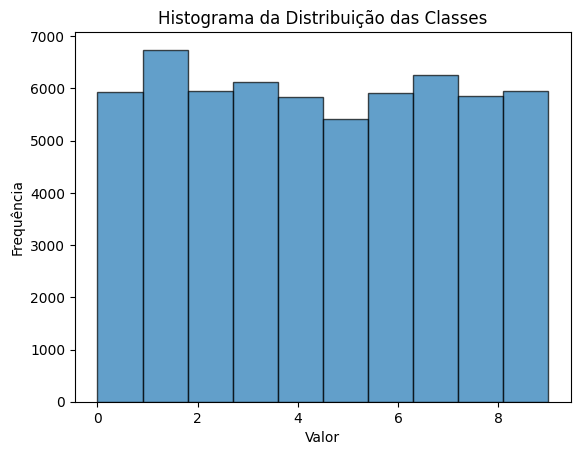

Valor da Mediana:  2.0997659635790997


Cal. Shapiro-Wilk, Statistica: 0.9799207448959 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.0478738754 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 2995.0180076081 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0


Tamanho do Dataset:  60000
Tamanho do divido pela Mediana:  60000
Entropia das imagens (Não-Ordenado | Original):  [(0, 2.134610479841256), (1, 2.182332956332523), (2, 2.0205475729478968), (3, 1.9146232633635833), (4, 2.0622959812409185)]  ...
Entropia das imagens (Ordenado | Valor):  [(57362, 1.4863968298643369), (37920, 1.496668095104714), (21618, 1.5087870641618106), (33124, 1.5365983764635436), (4064, 1.5366178955277268)]  ...
Entropia Total Acumulada:  125077.55333991128
Tamanho do Conjunto Analisado do Grafico a seguir:  60000
Tamanho do grupo 1 - 25% dos valores (Q1):  14968
Tamanho do grupo 2 - 50% dos 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


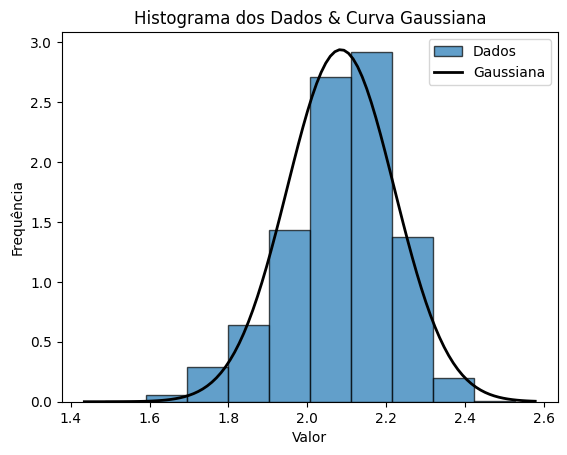

In [3]:
train_dataset_mnist, test_dataset_mnist, user_groups_train_mnist, user_groups_test_mnist, all_images_np = pegarDadosIDDMNIST()
#base = 0, ftupla = 0 : distribuição dos dados completos
#base = 1, ftupla = 1 : distribuição dos dados a esquerda da mediana
#base = 2, ftupla = 1 : distribuição dos dados a direita da mediana
train_X, tuplasEntropia, entropiesLocal_ordenado= iEMM(all_images_np, base = 0, ftupla = 0)
hipoteseNula(tuplasEntropia)
entropiaEstatisticas(train_X, tuplasEntropia, entropiesLocal_ordenado)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/mnist/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
(60000, 28, 28)


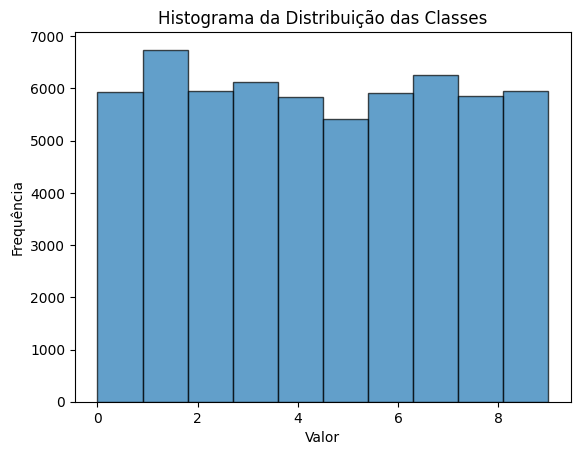

Valor da Mediana:  2.0997659635790997


Cal. Shapiro-Wilk, Statistica: 0.9006330966949 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.1142135550 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 4476.6022599382 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0


Tamanho do Dataset:  30000
Tamanho do divido pela Mediana:  30000
Entropia das imagens (Não-Ordenado | Original):  [(57362, 1.4863968298643369), (37920, 1.496668095104714), (21618, 1.5087870641618106), (33124, 1.5365983764635436), (4064, 1.5366178955277268)]  ...
Entropia das imagens (Ordenado | Valor):  [(57362, 1.4863968298643369), (37920, 1.496668095104714), (21618, 1.5087870641618106), (33124, 1.5365983764635436), (4064, 1.5366178955277268)]  ...
Entropia Total Acumulada:  59348.05239393675
Tamanho do Conjunto Analisado do Grafico a seguir:  30000
Tamanho do grupo 1 - 25% dos valores (Q1):  8068
Tamanho do 

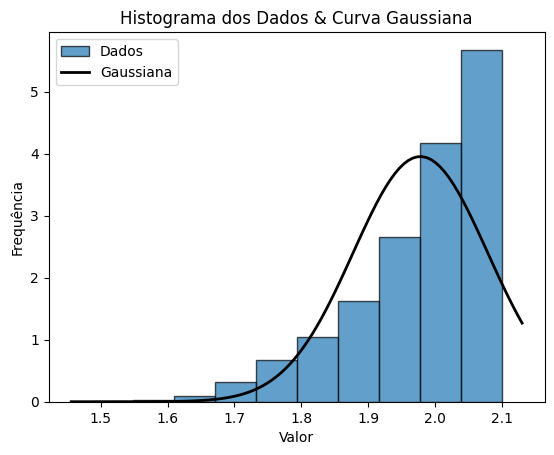

In [4]:
train_dataset_mnist, test_dataset_mnist, user_groups_train_mnist, user_groups_test_mnist, all_images_np = pegarDadosIDDMNIST()
#base = 0, ftupla = 0 : distribuição dos dados completos
#base = 1, ftupla = 1 : distribuição dos dados a esquerda da mediana
#base = 2, ftupla = 1 : distribuição dos dados a direita da mediana
train_X, tuplasEntropia, entropiesLocal_ordenado= iEMM(all_images_np, base = 1, ftupla = 1)
hipoteseNula(tuplasEntropia)
entropiaEstatisticas(train_X, tuplasEntropia, entropiesLocal_ordenado)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/mnist/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
(60000, 28, 28)


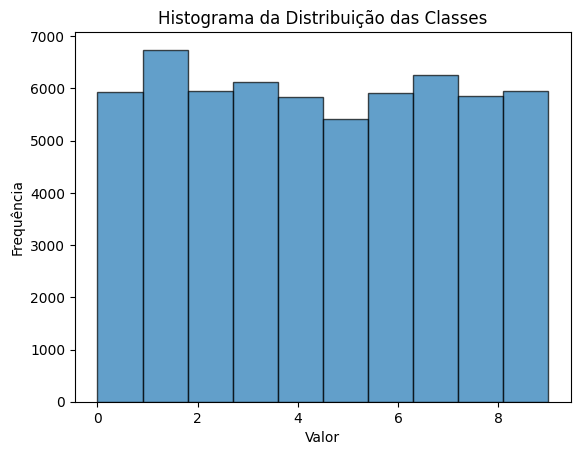

Valor da Mediana:  2.0997659635790997


Cal. Shapiro-Wilk, Statistica: 0.9480972290039 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.0772940409 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 2264.8366865111 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0


Tamanho do Dataset:  30000
Tamanho do divido pela Mediana:  30000
Entropia das imagens (Não-Ordenado | Original):  [(58169, 2.0997662173702403), (18995, 2.099766242161026), (54118, 2.0997675691529243), (44020, 2.099768154393837), (58094, 2.0997716491042184)]  ...
Entropia das imagens (Ordenado | Valor):  [(57362, 1.4863968298643369), (37920, 1.496668095104714), (21618, 1.5087870641618106), (33124, 1.5365983764635436), (4064, 1.5366178955277268)]  ...
Entropia Total Acumulada:  65729.50094597536
Tamanho do Conjunto Analisado do Grafico a seguir:  30000
Tamanho do grupo 1 - 25% dos valores (Q1):  7751
Tamanho do 

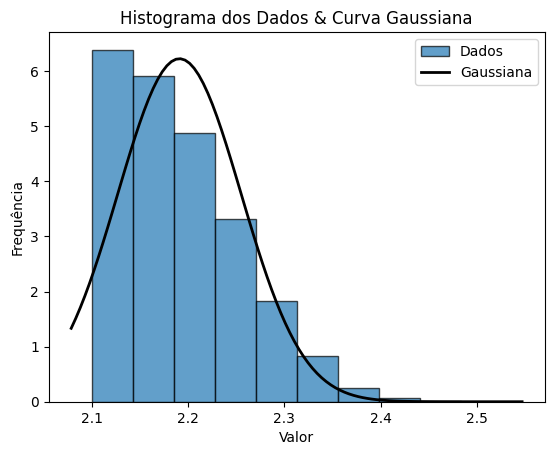

In [5]:
train_dataset_mnist, test_dataset_mnist, user_groups_train_mnist, user_groups_test_mnist, all_images_np = pegarDadosIDDMNIST()
#base = 0, ftupla = 0 : distribuição dos dados completos
#base = 1, ftupla = 1 : distribuição dos dados a esquerda da mediana
#base = 2, ftupla = 1 : distribuição dos dados a direita da mediana
train_X, tuplasEntropia, entropiesLocal_ordenado= iEMM(all_images_np, base = 2, ftupla = 1)
hipoteseNula(tuplasEntropia)
entropiaEstatisticas(train_X, tuplasEntropia, entropiesLocal_ordenado)

### Funções [NON-IDD DATASET]

In [6]:
from mnist_noniid import get_dataset_mnist_extr_noniid
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import kstest, norm
from scipy import stats

def entropiaBR(pk, base=10):
    pk = pk / np.sum(pk)
    pk = pk[pk > 0]
    result = -np.sum(pk * np.log(pk) / np.log(base))
    result = round(result, 17)
    return result

def indicesEntropiaMedianMnist(train_X):
  train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))   # Ajuste da dimensão
  train_X = train_X.astype("float")/255.0     # Normalização
  tuplasEntropia = [(index, entropiaBR(img.flatten())) for index, img in enumerate(train_X)]
  entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
  n = len(entropiesLocal_ordenado)
  if n % 2 == 1:
      median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
  else:
      median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
  indices_filtrados = np.array([item[0] for item in entropiesLocal_ordenado if item[1] <= median])  #selecionando os indices de entropia entropia baixa abaixo da mediana.
  #indices_filtrados = np.array([item[0] for item in entropiesLocal_ordenado if item[1] >= median])  #selecionando os indices de entropia entropia baixa abaixo da mediana.
  print('Valor da Mediana: ', median)
  train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
  #tuplasEntropia = np.array([tuplasEntropia[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
  return train_X, tuplasEntropia, entropiesLocal_ordenado

def mnistNONIDD(num_users_mnist = 400, nclass_mnist = 2, nsamples_mnist = 20, rate_unbalance_mnist = 1.0, p = 100, q = 5, plotar = 5):
  #Tratamento de erros
  num_users_mnist = 400 if num_users_mnist == 0 else num_users_mnist
  nclass_mnist = 2 if nclass_mnist == 0 else nclass_mnist
  nsamples_mnist = 20 if nsamples_mnist == 0 else  nsamples_mnist
  rate_unbalance_mnist = 1.0 if rate_unbalance_mnist == 0.0 else rate_unbalance_mnist
  p = 100 if p == 0 else p
  q = 5 if q == 0 else q
  plotar = 5 if plotar == 0 else plotar

  print("Dados da Importação: ")
  train_dataset_mnist, test_dataset_mnist, user_groups_train_mnist, user_groups_test_mnist = get_dataset_mnist_extr_noniid(num_users_mnist, nclass_mnist, nsamples_mnist, rate_unbalance_mnist)
  print("\n")
  print("Informações Gerais do Conjunto de Dados")
  print(f"Total de usuarios: {len(user_groups_train_mnist)}")

  if p == 1:
   for i in (range(int(len(user_groups_train_mnist)))):
     print(f"Grupo {i}: ", user_groups_train_mnist[i][:q], " ... ", user_groups_train_mnist[i][(nsamples_mnist - q):nsamples_mnist])   #imprimindo os 5 primeiros e os 5 ultimos de cada grupo
  elif p >= 2:
    for i in (range(int(len(user_groups_train_mnist)/p))):
      print(f"Grupo {i}: ", user_groups_train_mnist[i][:q], " ... ", user_groups_train_mnist[i][(nsamples_mnist - q):nsamples_mnist])   #imprimindo os 5 primeiros e os 5 ultimos de cada grupo
    print("\n")
    print("Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]")
    print("Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]")
    print("Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]")
    print("Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]")
    print("\n")
    g = (len(user_groups_train_mnist) - int(len(user_groups_train_mnist)/p))
    for g in range(g, len(user_groups_train_mnist)):
      print(f"Grupo {g}: ", user_groups_train_mnist[g][:q], " ... ", user_groups_train_mnist[g][(nsamples_mnist - q):nsamples_mnist])

  # Desnormalizando as imagens
  mean, std = 0.1307, 0.3081
  datasetGauss = []
  # Iterando sobre cada conjunto de índices de usuário
  n = int(num_users_mnist/p) # qtd de imagens apartir da primeira que deseja imprimir
  print("\n")
  print(f"Calculando os valores para {n} Grupos: ")
  for user_idx in range(n):  # Agora, só itera sobre os primeiros `n` grupos
      all_images_np = [train_dataset_mnist[int(i)][0].numpy().squeeze() for i in user_groups_train_mnist[user_idx]]
      all_images_np = np.stack(all_images_np)

      #Removendo a mudança ao qual deixa os dados
      all_images_np = all_images_np * std + mean
      all_images_np = np.clip(all_images_np, 0, 1)  # Clipping para garantir que a imagem esteja no intervalo [0,1]

      print(f"\nImagens do Grupo {user_idx+1}:")
      fig, axes = plt.subplots(1, plotar, figsize=(15,3))  # Criando 5 subplots lado a lado
      for idx, ax in enumerate(axes):
          image = all_images_np[idx]
          ax.imshow(image, cmap='gray')
          ax.set_title(f"I:{idx+1}")
          ax.axis('off')  # Para não mostrar os eixos
      plt.tight_layout()  # Ajusta o layout para evitar sobreposições
      plt.show()

      #Calculando o valor da entropia para o Indice atual
      train_x, tuplasEntropia, entropiesLocal_ordenado = indicesEntropiaMedianMnist(all_images_np)
      e = 2  # para imprimir os primeiros e últimos 5 elementos
      arr = train_x[0].flatten()
      output_str = "Valores do dataset Original (Chave|Valor): [" + ' '.join(map(str, arr[:e])) + " ... " + ' '.join(map(str, arr[-e:])) + "] ..."
      print(output_str)
      print("Valores do Conjunto (Chave|Valor) Não-Ordenado: ", tuplasEntropia[:q], " ...")
      print("Valores do Conjunto (Chave|Valor) Ordenado: ", entropiesLocal_ordenado[:q] , " ...")

      print("\n")
      valEntr = [(ento[1]) for ento in (tuplasEntropia)]
      xEnt = np.array(valEntr)
      #Shapiro-Wilk:
      statSW, pSW = stats.shapiro(xEnt)  # Obtém a estatística de teste e o valor-p
      validacaoSW = "Não Rejeitamos H0" if pSW > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
      print("Cal. Shapiro-Wilk, Statistica: %.13f" % statSW, "Valor-p: %.10f" % pSW, "Validação de Hipotese H0:", validacaoSW)
      #Kolmogorov-Smirnov
      mu, std_dev = np.mean(xEnt), np.std(xEnt)
      statKS, pKS = kstest(xEnt, 'norm', args=(mu, std_dev))
      validacaoKS = "Não Rejeitamos H0" if pKS > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
      print("Cal. Kolmogorov-Smirnov, Statistica: %.10f" % statKS, "Valor-p: %.10f" % pKS, "Validação de Hipotese H0:", validacaoKS)
      #D'Agostino e Pearson's
      statAP, pAP = normaltest(xEnt)
      validacaoAP = "Não Rejeitamos H0" if pAP > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
      print("Cal. D'Agostino e Pearson's, Statistica: %.10f" % statAP, "Valor-p: %.10f" % pAP, "Validação de Hipotese H0:", validacaoAP)

      if (validacaoSW == "Não Rejeitamos H0" and validacaoKS == "Não Rejeitamos H0") or \
        (validacaoSW == "Não Rejeitamos H0" and validacaoAP == "Não Rejeitamos H0") or \
        (validacaoSW == "Não Rejeitamos H0" and validacaoKS == "Não Rejeitamos H0" and validacaoAP == "Não Rejeitamos H0"):
        print("Com base em uma validação dupla identificamos de que não há evidência suficiente para rejeitar a hipótese nula. A amostra parece seguir uma distribuição normal.")
        datasetGauss.append(train_x)
      print("\n")

      plt.hist(valEntr, bins=10, edgecolor='black', alpha=0.7, density=True, label="Dados")
      xmin, xmax = plt.xlim()
      mu, std_dev = np.mean(valEntr), np.std(valEntr)
      x = np.linspace(xmin, xmax, 100)
      y = norm.pdf(x, mu, std_dev)
      plt.plot(x, y, 'k-', lw=2, label='Curva Gaussiana')
      plt.title(f'Histograma dos Dados & Curva Gaussiana para o Usuário {user_idx}')
      plt.xlabel('Valor')
      plt.ylabel('Frequência')
      plt.legend()
      plt.show()

  print("Total de Distribuições Gaussianas Encontradas: ", len(datasetGauss), "| Total de Usuarios de até: ", len(user_groups_train_mnist))
  return datasetGauss

Dados da Importação: 


Informações Gerais do Conjunto de Dados
Total de usuarios: 400
Grupo 0:  [ 4923.  4922. 16792.  9237. 16788.]  ...  [ 4910. 24277. 24266. 46309. 31797.]
Grupo 1:  [50834. 53547. 11284. 11259. 11705.]  ...  [ 7771. 11467. 53671.  7767. 50672.]
Grupo 2:  [ 1713. 55853. 58593. 58552.  6523.]  ...  [ 1758.  1749.  6512. 51078. 54705.]
Grupo 3:  [14665. 14250. 45976. 45938. 14975.]  ...  [15021. 12308. 45968. 48428. 17222.]


Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]
Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]
Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]
Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]


Grupo 396:  [40301. 38049. 36337. 36119. 22631.]  ...  [24196. 38089. 42678. 29061. 38053.]
Grupo 397:  [47774. 37675. 15043. 47761. 34783.]  ...  [51269. 13101. 50865. 27504. 2

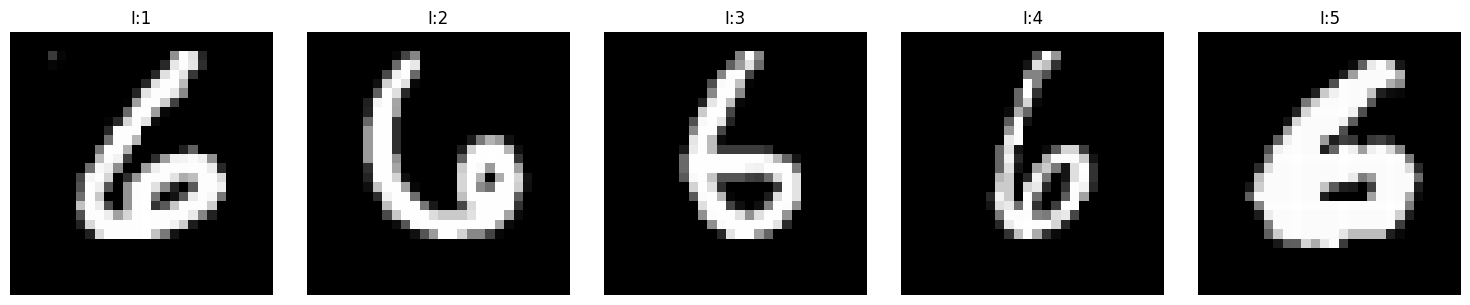

Valor da Mediana:  2.063540646557198
Valores do dataset Original (Chave|Valor): [0.0 0.0 ... 0.0 0.0] ...
Valores do Conjunto (Chave|Valor) Não-Ordenado:  [(0, 2.188885549125599), (1, 2.149962031493259), (2, 2.090915507124596), (3, 1.9702725136207433), (4, 2.345357124372682)]  ...
Valores do Conjunto (Chave|Valor) Ordenado:  [(35, 1.8512093574695894), (30, 1.8633152227957501), (32, 1.8738640020210169), (28, 1.906196626766254), (34, 1.911641305112724)]  ...


Cal. Shapiro-Wilk, Statistica: 0.9803077578545 Valor-p: 0.7009789944 Validação de Hipotese H0: Não Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.0985270193 Valor-p: 0.7963697576 Validação de Hipotese H0: Não Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 1.2642111287 Valor-p: 0.5314715745 Validação de Hipotese H0: Não Rejeitamos H0
Com base em uma validação dupla identificamos de que não há evidência suficiente para rejeitar a hipótese nula. A amostra parece seguir uma distribuição normal.




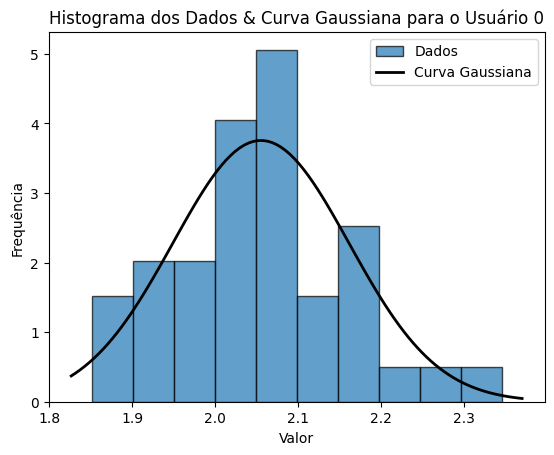


Imagens do Grupo 2:


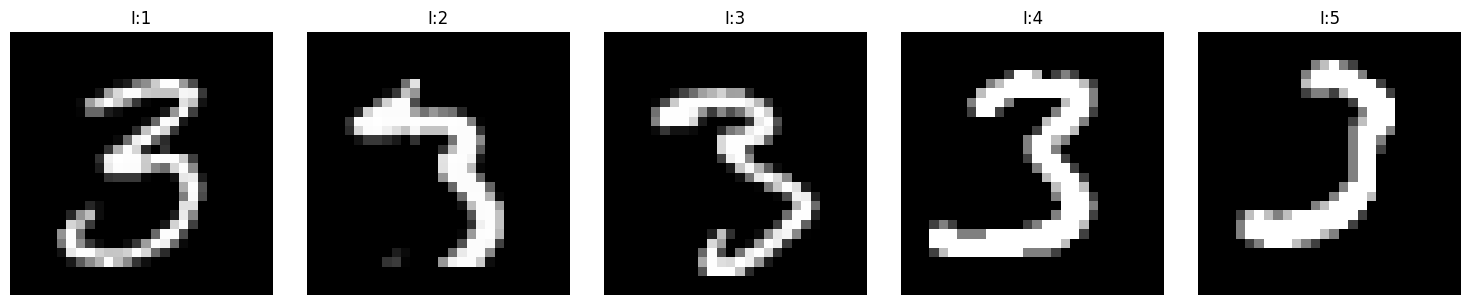

Valor da Mediana:  2.0971735139520518
Valores do dataset Original (Chave|Valor): [0.0 0.0 ... 0.0 0.0] ...
Valores do Conjunto (Chave|Valor) Não-Ordenado:  [(0, 2.099491290604078), (1, 2.048258340329869), (2, 2.073706632123785), (3, 2.167905590599445), (4, 2.0788737696751727)]  ...
Valores do Conjunto (Chave|Valor) Ordenado:  [(9, 1.8824529949864621), (21, 1.9198786303607396), (33, 1.9375095285677708), (36, 1.9542634577083615), (25, 1.990147205977747)]  ...


Cal. Shapiro-Wilk, Statistica: 0.9706788659096 Valor-p: 0.3780823052 Validação de Hipotese H0: Não Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.1410471217 Valor-p: 0.3690500340 Validação de Hipotese H0: Não Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 1.1144280620 Valor-p: 0.5728026534 Validação de Hipotese H0: Não Rejeitamos H0
Com base em uma validação dupla identificamos de que não há evidência suficiente para rejeitar a hipótese nula. A amostra parece seguir uma distribuição normal.




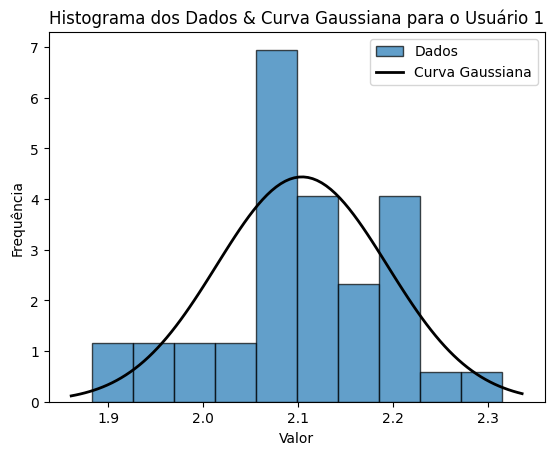


Imagens do Grupo 3:


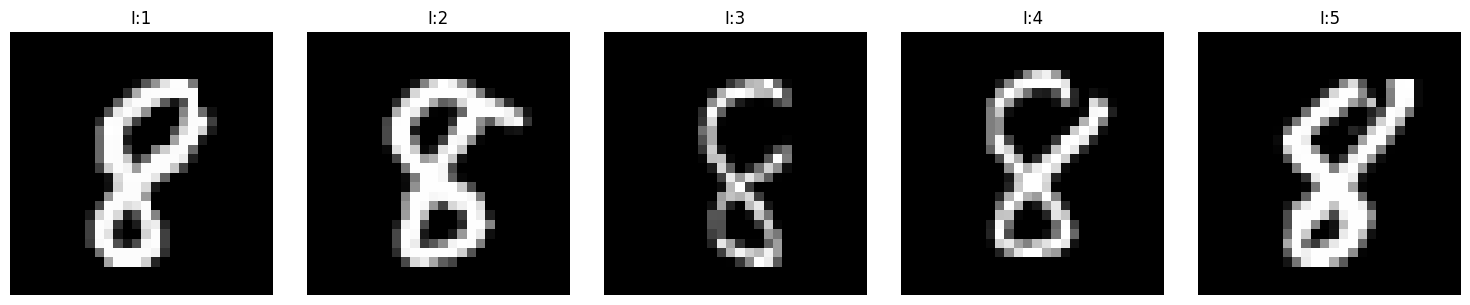

Valor da Mediana:  2.1274232474408565
Valores do dataset Original (Chave|Valor): [0.0 0.0 ... 0.0 0.0] ...
Valores do Conjunto (Chave|Valor) Não-Ordenado:  [(0, 2.1349365336721533), (1, 2.1832621938624426), (2, 1.9366828365193087), (3, 2.0743610335470404), (4, 2.1802109584715748)]  ...
Valores do Conjunto (Chave|Valor) Ordenado:  [(33, 1.830783855330069), (23, 1.8703085460646425), (32, 1.8840642331700428), (26, 1.9355042516053993), (2, 1.9366828365193087)]  ...


Cal. Shapiro-Wilk, Statistica: 0.9414039254189 Valor-p: 0.0385683514 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.1421028221 Valor-p: 0.3602003706 Validação de Hipotese H0: Não Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 3.4486554504 Valor-p: 0.1782928733 Validação de Hipotese H0: Não Rejeitamos H0




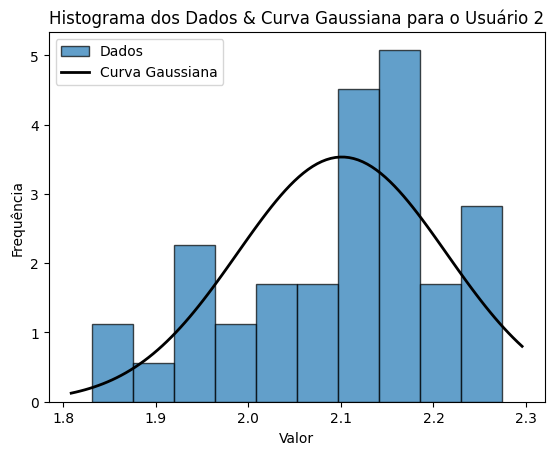


Imagens do Grupo 4:


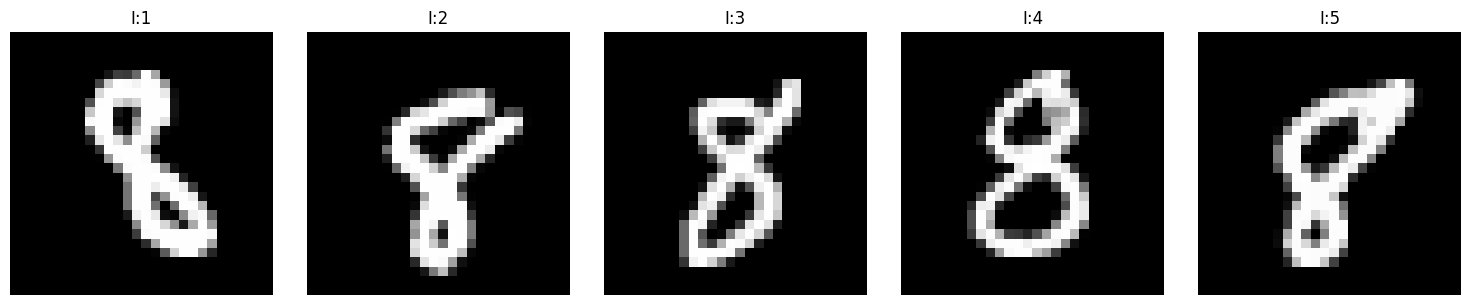

Valor da Mediana:  2.1479212525187252
Valores do dataset Original (Chave|Valor): [0.0 0.0 ... 0.0 0.0] ...
Valores do Conjunto (Chave|Valor) Não-Ordenado:  [(0, 2.148377246311883), (1, 2.14273959146487), (2, 2.129190518708713), (3, 2.1474652587255676), (4, 2.1680675485665977)]  ...
Valores do Conjunto (Chave|Valor) Ordenado:  [(35, 1.9289456208800237), (5, 1.971634617222238), (39, 1.9802181946027706), (8, 2.005972300324896), (12, 2.0063584248616686)]  ...


Cal. Shapiro-Wilk, Statistica: 0.9712221026421 Valor-p: 0.3931308985 Validação de Hipotese H0: Não Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.1145443939 Valor-p: 0.6288596320 Validação de Hipotese H0: Não Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 0.9156710026 Valor-p: 0.6326515380 Validação de Hipotese H0: Não Rejeitamos H0
Com base em uma validação dupla identificamos de que não há evidência suficiente para rejeitar a hipótese nula. A amostra parece seguir uma distribuição normal.




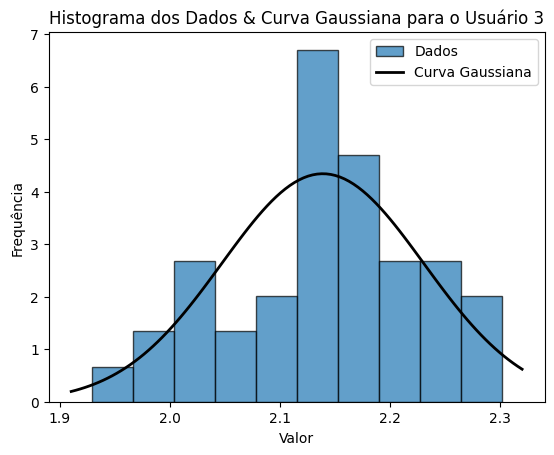

Total de Distribuições Gaussianas Encontradas:  3 | Total de Usuarios de até:  400


In [7]:
datasetGauss = mnistNONIDD(num_users_mnist = 400, nclass_mnist = 2, nsamples_mnist = 20, rate_unbalance_mnist = 1.0, p = 100, q = 5, plotar = 5)

# Conjunto de Dados [Cifar10]

## Funções [DADOS IDD]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from keras.src.utils.np_utils import to_categorical
from tensorflow.keras.datasets import cifar10
import time
from cifar10_noniid import get_dataset_cifar10_extr_noniid
from scipy.stats import norm
from scipy.stats import kstest
from scipy.stats import normaltest
from scipy import stats


def entropiaBR(pk, base=10):
    pk = pk / np.sum(pk)
    pk = pk[pk > 0]
    result = -np.sum(pk * np.log(pk) / np.log(base))
    result = round(result, 17)
    return result

def pegarDadosIDDCifar():
  num_users_cifar = 1
  nclass_cifar = 9
  nsamples_cifar = 1
  rate_unbalance_cifar = 0.0
  train_dataset_cifar, test_dataset_cifar, user_groups_train_cifar, user_groups_test_cifar = get_dataset_cifar10_extr_noniid(num_users_cifar, nclass_cifar, nsamples_cifar, rate_unbalance_cifar)
  print(train_dataset_cifar)
  all_images = [img[0].numpy().squeeze() for img in train_dataset_cifar]
  all_images_np = np.stack(all_images)
  #Removendo a mudança ao qual deixa os dados
  mean_rgb = np.array([0.4914, 0.4822, 0.4465])
  std_rgb = np.array([0.2023, 0.1994, 0.201])
  all_images_np = all_images_np * std_rgb[:, None, None] + mean_rgb[:, None, None]
  #all_images_np = np.transpose(all_images_np[0], (1, 2, 0))
  print(all_images_np.shape)
  # Selecione a primeira imagem
  image = all_images_np[0]
  # Exiba a imagem
  image = image
  plt.show()
  # Extracting the labels from the train_dataset_mnist
  all_labels = [lbl for _, lbl in train_dataset_cifar]
  # Plotting the histogram
  plt.hist(all_labels, bins=10, edgecolor='black', alpha=0.7)
  plt.title('Histograma dos Dados: Distribuição das Classes')
  plt.xlabel('Valor')
  plt.ylabel('Frequência')
  plt.show()
  return train_dataset_cifar, test_dataset_cifar, user_groups_train_cifar, user_groups_test_cifar, all_images_np

def iEMC(train_X, base = 0, ftupla = 0):
  train_X = train_X.astype("float")/255.0     # Normalização
  tuplasEntropia = [(index, entropiaBR(img.flatten())) for index, img in enumerate(train_X)]
  entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
  n = len(entropiesLocal_ordenado)
  if n % 2 == 1:
      median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
  else:
      median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
  print('Valor da Mediana: ', median)
  if base == 1:
    indices_filtrados = np.array([item[0] for item in entropiesLocal_ordenado if item[1] <= median])  #selecionando os indices de entropia entropia baixa abaixo da mediana.
  elif base == 2:
    indices_filtrados = np.array([item[0] for item in entropiesLocal_ordenado if item[1] >= median])  #selecionando os indices de entropia entropia baixa abaixo da mediana.
  if base != 0:
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
  if ftupla == 1:
    # tuplasEntropia = np.array([tuplasEntropia[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    tuplasEntropia = ([tuplasEntropia[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
  return train_X, tuplasEntropia, entropiesLocal_ordenado

def entropiaEstatisticas(train_X, tuplasEntropia, entropiesLocal_ordenado):
  print("Tamanho do Dataset: ", len(tuplasEntropia))
  print("Tamanho do divido pela Mediana: ", len(train_X))
  print("Entropia das imagens (Não-Ordenado | Original): ", tuplasEntropia[:5], " ...")
  print("Entropia das imagens (Ordenado | Valor): ", entropiesLocal_ordenado[:5], " ...")

  valEnt = [(ento[1]) for ento in (tuplasEntropia)]
  soma = sum(valEnt)
  print("Entropia Total Acumulada: ", soma)
  alvos = [0.25 * soma, 0.5 * soma, 0.75 * soma, soma]
  grupos = []
  grupo_atual = []
  soma_acumulada = 0
  index_alvo = 0
  for num in valEnt:
      grupo_atual.append(num)
      soma_acumulada += num
      if soma_acumulada >= alvos[index_alvo]:
          grupos.append(grupo_atual)
          grupo_atual = []
          index_alvo += 1
          if index_alvo == 4:
              break
  if grupo_atual:
      grupos.append(grupo_atual)

  print("Tamanho do Conjunto Analisado do Grafico a seguir: ", len(valEnt))
  print("Tamanho do grupo 1 - 25% dos valores (Q1): ", len(grupos[0]))
  print("Tamanho do grupo 2 - 50% dos valores (Q2): ", len(grupos[1]))
  print("Tamanho do grupo 3 - 75% dos valores (Q3): ", len(grupos[2]))
  print("Tamanho do grupo 4 - 100% dos valores (Q4): ", len(grupos[3]))

  # Calcula a média e o desvio padrão dos dados
  mu, std = np.mean(valEnt), np.std(valEnt)
  # Histograma dos dados
  plt.hist(valEnt, bins=10, edgecolor='black', alpha=0.7, density=True, label="Dados")
  # Cria um array linearmente espaçado para a curva
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  # Calcula a PDF da distribuição normal para cada valor de x
  p = norm.pdf(x, mu, std)
  # Plota a curva gaussiana
  plt.plot(x, p, 'k', linewidth=2, label="Gaussiana")
  # Configurações adicionais e exibição do gráfico
  plt.title('Histograma dos Dados & Curva Gaussiana')
  plt.xlabel('Valor')
  plt.ylabel('Frequência')
  plt.legend()
  plt.show()


def hipoteseNula(tuplasEntropia):
  print("\n")
  xEnt = [(ento[1]) for ento in (tuplasEntropia)]
  mu, std_dev = np.mean(xEnt), np.std(xEnt)
  #Shapiro-Wilk:
  statSW, pSW = stats.shapiro(xEnt)  # Obtém a estatística de teste e o valor-p
  validacaoSW = "Não Rejeitamos H0" if pSW > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
  print("Cal. Shapiro-Wilk, Statistica: %.13f" % statSW, "Valor-p: %.10f" % pSW, "Validação de Hipotese H0:", validacaoSW)
  #Kolmogorov-Smirnov
  mu, std_dev = np.mean(xEnt), np.std(xEnt)
  statKS, pKS = kstest(xEnt, 'norm', args=(mu, std_dev))
  validacaoKS = "Não Rejeitamos H0" if pKS > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
  print("Cal. Kolmogorov-Smirnov, Statistica: %.10f" % statKS, "Valor-p: %.10f" % pKS, "Validação de Hipotese H0:", validacaoKS)
  #D'Agostino e Pearson's
  statAP, pAP = normaltest(xEnt)
  validacaoAP = "Não Rejeitamos H0" if pAP > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
  print("Cal. D'Agostino e Pearson's, Statistica: %.10f" % statAP, "Valor-p: %.10f" % pAP, "Validação de Hipotese H0:", validacaoAP)

  if (validacaoSW == "Não Rejeitamos H0" and validacaoKS == "Não Rejeitamos H0") or \
    (validacaoSW == "Não Rejeitamos H0" and validacaoAP == "Não Rejeitamos H0") or \
    (validacaoSW == "Não Rejeitamos H0" and validacaoKS == "Não Rejeitamos H0" and validacaoAP == "Não Rejeitamos H0"):
    print("Com base em uma validação dupla identificamos de que não há evidência suficiente para rejeitar a hipótese nula. A amostra parece seguir uma distribuição normal.")
  print("\n")

100%|██████████| 170498071/170498071 [00:01<00:00, 104782082.91it/s]


Extracting ../data/cifar/cifar-10-python.tar.gz to ../data/cifar/
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/cifar/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
(50000, 3, 32, 32)


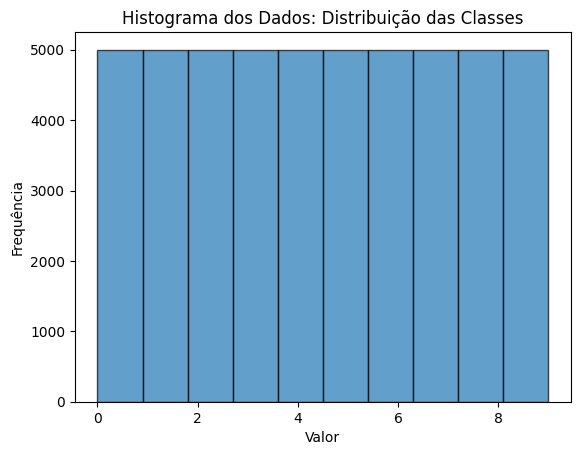

Valor da Mediana:  3.4391391189425513


Cal. Shapiro-Wilk, Statistica: 0.7686557173729 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.1235865374 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 36469.0304106366 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0


Tamanho do Dataset:  50000
Tamanho do divido pela Mediana:  50000
Entropia das imagens (Não-Ordenado | Original):  [(0, 3.430728644012745), (1, 3.4374156558985836), (2, 3.4058349364935303), (3, 3.4455610155682344), (4, 3.4067843172503887)]  ...
Entropia das imagens (Ordenado | Valor):  [(40350, 2.7438191673583234), (44590, 2.753764407125833), (20331, 2.8478593416877898), (7159, 2.873459525680964), (13248, 2.898485078314)]  ...
Entropia Total Acumulada:  171463.6302992465
Tamanho do Conjunto Analisado do Grafico a seguir:  50000
Tamanho do grupo 1 - 25% dos valores (Q1):  12501
Tamanho do grupo 2 - 50% dos valo

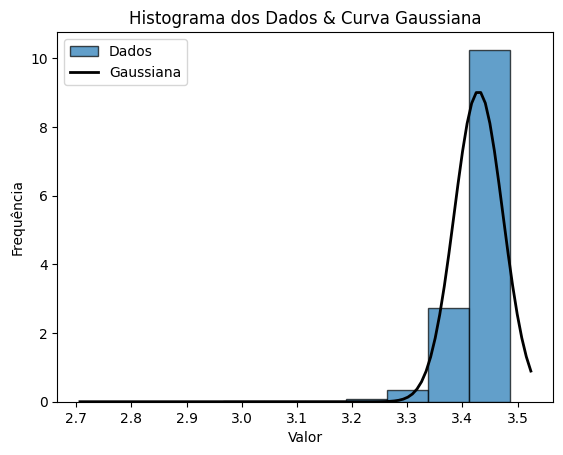

In [9]:
train_dataset_cifar, test_dataset_cifar, user_groups_train_cifar, user_groups_test_cifar, all_images_np = pegarDadosIDDCifar()
#base = 0, ftupla = 0 : distribuição dos dados completos
#base = 1, ftupla = 1 : distribuição dos dados a esquerda da mediana
#base = 2, ftupla = 1 : distribuição dos dados a direita da mediana
train_X, tuplasEntropia, entropiesLocal_ordenado= iEMC(all_images_np, base = 0, ftupla = 0)
hipoteseNula(tuplasEntropia)
entropiaEstatisticas(train_X, tuplasEntropia, entropiesLocal_ordenado)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/cifar/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
(50000, 3, 32, 32)


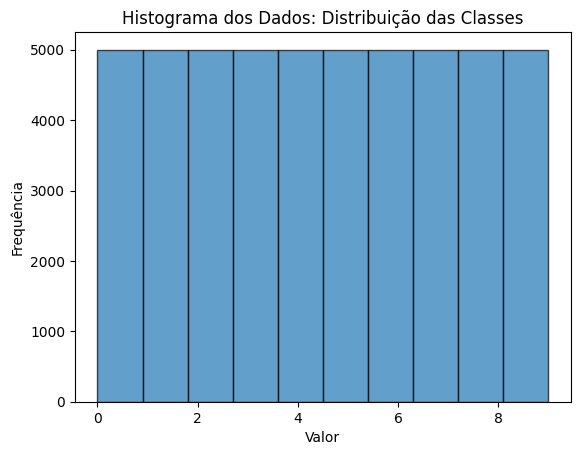

Valor da Mediana:  3.4391391189425513


Cal. Shapiro-Wilk, Statistica: 0.6688580513000 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.2051777255 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 20511.5552024197 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0


Tamanho do Dataset:  25000
Tamanho do divido pela Mediana:  25000
Entropia das imagens (Não-Ordenado | Original):  [(40350, 2.7438191673583234), (44590, 2.753764407125833), (20331, 2.8478593416877898), (7159, 2.873459525680964), (13248, 2.898485078314)]  ...
Entropia das imagens (Ordenado | Valor):  [(40350, 2.7438191673583234), (44590, 2.753764407125833), (20331, 2.8478593416877898), (7159, 2.873459525680964), (13248, 2.898485078314)]  ...
Entropia Total Acumulada:  85022.73654470604
Tamanho do Conjunto Analisado do Grafico a seguir:  25000
Tamanho do grupo 1 - 25% dos valores (Q1):  6355
Tamanho do grupo 2 -

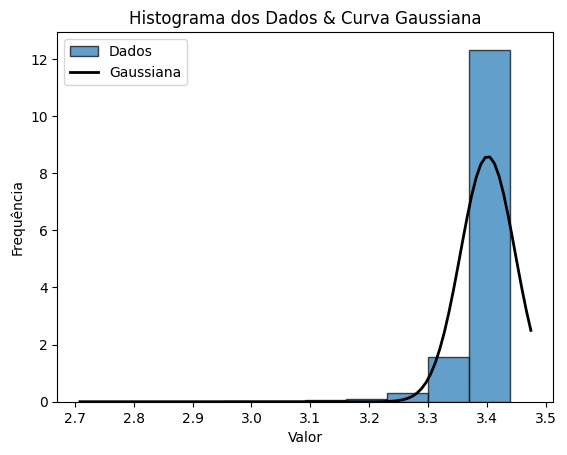

In [10]:
train_dataset_cifar, test_dataset_cifar, user_groups_train_cifar, user_groups_test_cifar, all_images_np = pegarDadosIDDCifar()
#base = 0, ftupla = 0 : distribuição dos dados completos
#base = 1, ftupla = 1 : distribuição dos dados a esquerda da mediana
#base = 2, ftupla = 1 : distribuição dos dados a direita da mediana
train_X, tuplasEntropia, entropiesLocal_ordenado= iEMC(all_images_np, base = 1, ftupla = 1)
hipoteseNula(tuplasEntropia)
entropiaEstatisticas(train_X, tuplasEntropia, entropiesLocal_ordenado)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/cifar/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
(50000, 3, 32, 32)


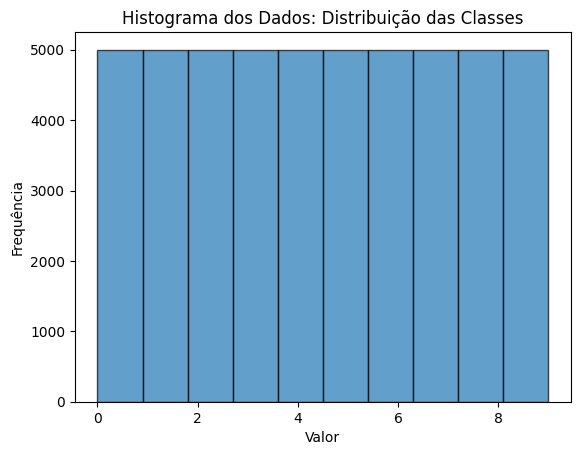

Valor da Mediana:  3.4391391189425513


Cal. Shapiro-Wilk, Statistica: 0.9700769186020 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.0536348494 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 3722.3176835508 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0


Tamanho do Dataset:  25000
Tamanho do divido pela Mediana:  25000
Entropia das imagens (Não-Ordenado | Original):  [(2510, 3.4391400312579616), (20669, 3.4391416576968883), (17095, 3.439141761287311), (34552, 3.4391463545556045), (37742, 3.4391467907200077)]  ...
Entropia das imagens (Ordenado | Valor):  [(40350, 2.7438191673583234), (44590, 2.753764407125833), (20331, 2.8478593416877898), (7159, 2.873459525680964), (13248, 2.898485078314)]  ...
Entropia Total Acumulada:  86440.89375453908
Tamanho do Conjunto Analisado do Grafico a seguir:  25000
Tamanho do grupo 1 - 25% dos valores (Q1):  6276
Tamanho do grupo

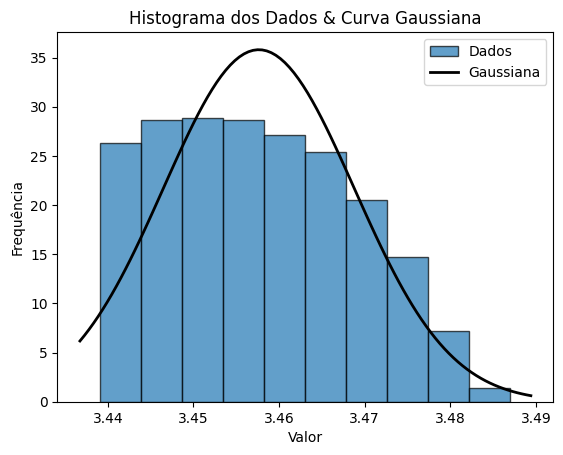

In [11]:
train_dataset_cifar, test_dataset_cifar, user_groups_train_cifar, user_groups_test_cifar, all_images_np = pegarDadosIDDCifar()
#base = 0, ftupla = 0 : distribuição dos dados completos
#base = 1, ftupla = 1 : distribuição dos dados a esquerda da mediana
#base = 2, ftupla = 1 : distribuição dos dados a direita da mediana
train_X, tuplasEntropia, entropiesLocal_ordenado= iEMC(all_images_np, base = 2, ftupla = 1)
hipoteseNula(tuplasEntropia)
entropiaEstatisticas(train_X, tuplasEntropia, entropiesLocal_ordenado)

## Cifar10 [Dados NON-IDD]

In [12]:
from cifar10_noniid import get_dataset_cifar10_extr_noniid
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import stats

def entropiaBR(pk, base=10):
    pk = pk / np.sum(pk)
    pk = pk[pk > 0]
    result = -np.sum(pk * np.log(pk) / np.log(base))
    result = round(result, 17)
    return result

def indicesEntropiaMedianCifar(train_X):
  # train_X = train_X.reshape((train_X.shape[0], 32, 32, 1))   # Ajuste da dimensão
  train_X = train_X.astype("float")/255.0     # Normalização
  tuplasEntropia = [(index, entropiaBR(img.flatten())) for index, img in enumerate(train_X)]
  entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
  n = len(entropiesLocal_ordenado)
  if n % 2 == 1:
      median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
  else:
      median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
  indices_filtrados = np.array([item[0] for item in entropiesLocal_ordenado if item[1] <= median])  #selecionando os indices de entropia entropia baixa abaixo da mediana.
  #indices_filtrados = np.array([item[0] for item in entropiesLocal_ordenado if item[1] >= median])  #selecionando os indices de entropia entropia baixa abaixo da mediana.
  print('Valor da Mediana: ', median)
  train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
  #tuplasEntropia = np.array([tuplasEntropia[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
  return train_X, tuplasEntropia, entropiesLocal_ordenado

def cifar10NONIDD(num_users_cifar = 400, nclass_cifar = 2, nsamples_cifar = 20, rate_unbalance_cifar = 1.0, p = 100, q = 5, plotar = 5):
  #Tratamento de erros
  num_users_cifar = 400 if num_users_cifar == 0 else num_users_cifar
  nclass_cifar = 2 if nclass_cifar == 0 else nclass_cifar
  nsamples_cifar = 20 if nsamples_cifar == 0 else  nsamples_cifar
  rate_unbalance_cifar = 1.0 if rate_unbalance_cifar == 0.0 else rate_unbalance_cifar
  p = 100 if p == 0 else p
  q = 5 if q == 0 else q
  plotar = 5 if plotar == 0 else plotar

  print("Dados da Importação: ")
  train_dataset_cifar, test_dataset_cifar, user_groups_train_cifar, user_groups_test_cifar = get_dataset_cifar10_extr_noniid(num_users_cifar, nclass_cifar, nsamples_cifar, rate_unbalance_cifar)
  print("\n")
  print("Informações Gerais do Conjunto de Dados")
  print(f"Total de usuarios: {len(user_groups_train_cifar)}")

  if p == 1:
   for i in (range(int(len(user_groups_train_cifar)))):
     print(f"Grupo {i}: ", user_groups_train_cifar[i][:q], " ... ", user_groups_train_cifar[i][(nsamples_cifar - q):nsamples_cifar])   #imprimindo os 5 primeiros e os 5 ultimos de cada grupo
  elif p >= 2:
    for i in (range(int(len(user_groups_train_cifar)/p))):
      print(f"Grupo {i}: ", user_groups_train_cifar[i][:q], " ... ", user_groups_train_cifar[i][(nsamples_cifar - q):nsamples_cifar])   #imprimindo os 5 primeiros e os 5 ultimos de cada grupo
    print("\n")
    print("Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]")
    print("Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]")
    print("Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]")
    print("Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]")
    print("\n")
    g = (len(user_groups_train_cifar) - int(len(user_groups_train_cifar)/p))
    for g in range(g, len(user_groups_train_cifar)):
      print(f"Grupo {g}: ", user_groups_train_cifar[g][:q], " ... ", user_groups_train_cifar[g][(nsamples_cifar - q):nsamples_cifar])

  # Desnormalizando as imagens
  mean_rgb = np.array([0.4914, 0.4822, 0.4465])
  std_rgb = np.array([0.2023, 0.1994, 0.201])

  # Iterando sobre cada conjunto de índices de usuário
  n = int(num_users_cifar/p) #qtd de imagens apartir da primeira que deseja imprimir
  print("\n")
  print(f"Calculando os valores para {n} Grupos: ")
  datasetGauss = []
  for user_idx in range(n):
      # Convertendo índices flutuantes para inteiros e obtemos as imagens usando esses índices
      all_images = [train_dataset_cifar[int(i)][0].numpy() for i in user_groups_train_cifar[user_idx]]
      all_images_np = np.stack(all_images)
      all_images_np = all_images_np * std_rgb[:, None, None] + mean_rgb[:, None, None]
      all_images_np = np.clip(all_images_np, 0, 1) # Clipping para garantir que a imagem esteja no intervalo [0,1]
      ##################################################################################
      print('\n')
      print('...... ......  ...... ......  ......  ......  ......  ...... ...... ...... ...... ...... ......  ...... ......  ......  ......  ......  ...... ...... ...... ......')
      print(f"Imagens do Grupo {user_idx}: ")
      fig, axes = plt.subplots(1, plotar, figsize=(15,3))  # Criando 5 subplots lado a lado
      for idx, ax in enumerate(axes):
          image = all_images_np[idx].transpose(1, 2, 0)
          ax.imshow(image)
          ax.set_title(f"Img {idx+1}")
          ax.axis('off')  # Para não mostrar os eixos
      plt.tight_layout()  # Ajusta o layout para evitar sobreposições
      plt.show()

      ##################################################################################
      #Calculando o valor da entropia para o Indice atual
      train_x, tuplasEntropia, entropiesLocal_ordenado = indicesEntropiaMedianCifar(all_images_np)
      e = 2  # para imprimir os primeiros e últimos 5 elementos
      arr = train_x[0].flatten()
      output_str = "Valores do dataset Original (Chave|Valor): [" + ' '.join(map(str, arr[:e])) + " ... " + ' '.join(map(str, arr[-e:])) + "] ..."
      print(output_str)
      print("Valores do Conjunto (Chave|Valor) Não-Ordenado: ", tuplasEntropia[:q], " ...")
      print("Valores do Conjunto (Chave|Valor) Ordenado: ", entropiesLocal_ordenado[:q] , " ...")


      print("\n")
      valEntr = [(ento[1]) for ento in (tuplasEntropia)]
      xEnt = np.array(valEntr)
      mu, std = np.mean(valEntr), np.std(valEntr)
      mu, std_dev = np.mean(xEnt), np.std(xEnt)
      #Shapiro-Wilk:
      statSW, pSW = stats.shapiro(xEnt)  # Obtém a estatística de teste e o valor-p
      validacaoSW = "Não Rejeitamos H0" if pSW > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
      print("Cal. Shapiro-Wilk, Statistica: %.13f" % statSW, "Valor-p: %.10f" % pSW, "Validação de Hipotese H0:", validacaoSW)
      #Kolmogorov-Smirnov
      mu, std_dev = np.mean(xEnt), np.std(xEnt)
      statKS, pKS = kstest(xEnt, 'norm', args=(mu, std_dev))
      validacaoKS = "Não Rejeitamos H0" if pKS > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
      print("Cal. Kolmogorov-Smirnov, Statistica: %.10f" % statKS, "Valor-p: %.10f" % pKS, "Validação de Hipotese H0:", validacaoKS)
      #D'Agostino e Pearson's
      statAP, pAP = normaltest(xEnt)
      validacaoAP = "Não Rejeitamos H0" if pAP > 0.05 else "Rejeitamos H0"  # Aqui, corrigimos a interpretação do valor-p
      print("Cal. D'Agostino e Pearson's, Statistica: %.10f" % statAP, "Valor-p: %.10f" % pAP, "Validação de Hipotese H0:", validacaoAP)

      if (validacaoSW == "Não Rejeitamos H0" and validacaoKS == "Não Rejeitamos H0") or \
        (validacaoSW == "Não Rejeitamos H0" and validacaoAP == "Não Rejeitamos H0") or \
        (validacaoSW == "Não Rejeitamos H0" and validacaoKS == "Não Rejeitamos H0" and validacaoAP == "Não Rejeitamos H0"):
        print("Com base em uma validação dupla identificamos de que não há evidência suficiente para rejeitar a hipótese nula. A amostra parece seguir uma distribuição normal.")
        datasetGauss.append(train_x)
      print("\n")


      plt.hist(valEntr, bins=10, edgecolor='black', alpha=0.7, density=True, label="Dados")
      xmin, xmax = plt.xlim()
      x = np.linspace(xmin, xmax, 100)
      p = norm.pdf(x, mu, std)
      plt.plot(x, p, 'k', linewidth=2, label="Gaussiana")
      plt.title(f'Histograma dos Dados & Curva Gaussiana para o Usuário {user_idx}')
      plt.xlabel('Valor')
      plt.ylabel('Frequência')
      plt.legend()
      plt.show()

  print("Total de Distribuições Gaussianas Encontradas: ", len(datasetGauss), "| Total de Usuarios de até: ", len(user_groups_train_cifar))
  return datasetGauss

Dados da Importação: 
Files already downloaded and verified
Files already downloaded and verified


Informações Gerais do Conjunto de Dados
Total de usuarios: 400
Grupo 0:  [39724. 40367. 39987. 39996. 40185.]  ...  [40290. 40296. 40297. 40311. 40341.]
Grupo 1:  [45987. 41077. 45981. 14566. 43049.]  ...  [33610. 30326. 43170. 45962. 17161.]
Grupo 2:  [22064.  1853. 19854. 39981. 40483.]  ...  [40512. 41225. 41714. 22010. 41712.]
Grupo 3:  [ 3794. 30622. 35748. 27941. 31017.]  ...  [36227. 33965. 31708. 33962. 36224.]


Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]
Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]
Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]
Grupo n:  [...... ......  ...... ......  ......]  ...  [......  ...... ...... ...... ......]


Grupo 396:  [44545. 44470. 44546. 44468.  8569.]  ...  [ 1243. 11612. 44443. 44454. 44461.]
Grupo 397

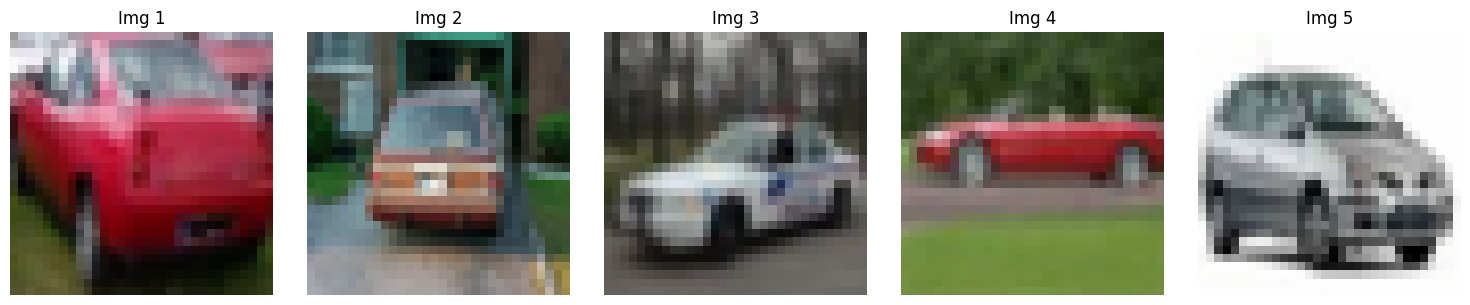

Valor da Mediana:  3.4276534520452664
Valores do dataset Original (Chave|Valor): [3.075734418981215e-05 3.075734418981215e-05 ... 1.537881271511883e-05 1.537881271511883e-05] ...
Valores do Conjunto (Chave|Valor) Não-Ordenado:  [(0, 3.356000009354949), (1, 3.4216712862420575), (2, 3.434995207864873), (3, 3.439445259545325), (4, 3.441183173970128)]  ...
Valores do Conjunto (Chave|Valor) Ordenado:  [(20, 3.1060207745768853), (30, 3.338779948638465), (18, 3.3506068201394936), (0, 3.356000009354949), (34, 3.3869760938248827)]  ...


Cal. Shapiro-Wilk, Statistica: 0.5664362907410 Valor-p: 0.0000000011 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.2620600467 Valor-p: 0.0065113836 Validação de Hipotese H0: Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 68.2101129985 Valor-p: 0.0000000000 Validação de Hipotese H0: Rejeitamos H0




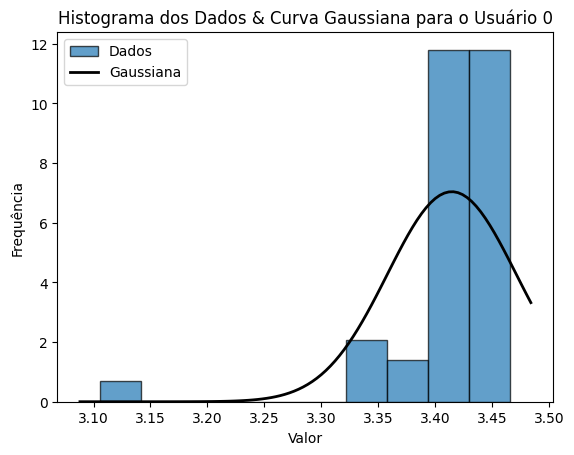



...... ......  ...... ......  ......  ......  ......  ...... ...... ...... ...... ...... ......  ...... ......  ......  ......  ......  ...... ...... ...... ......
Imagens do Grupo 1: 


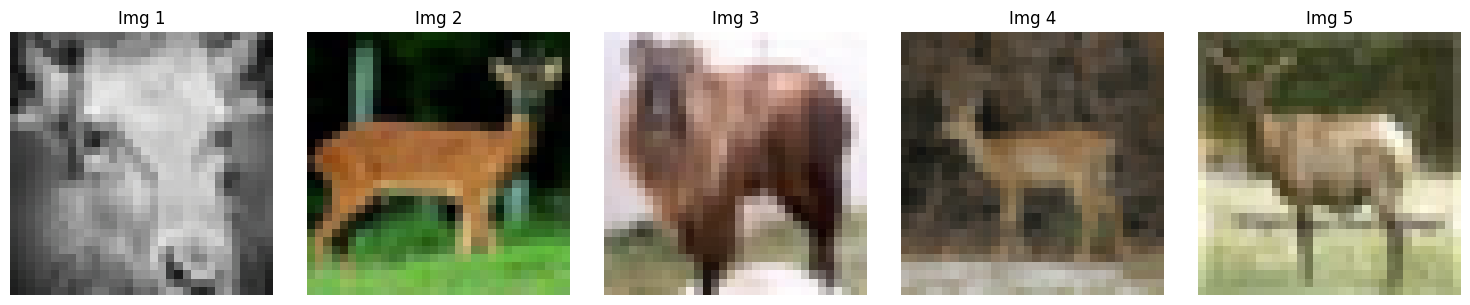

Valor da Mediana:  3.4478916874227603
Valores do dataset Original (Chave|Valor): [0.0011072665067747528 0.0009688581264252756 ... 0.001814686650534471 0.0017531718562037557] ...
Valores do Conjunto (Chave|Valor) Não-Ordenado:  [(0, 3.448552516593648), (1, 3.309969667998838), (2, 3.424246092525719), (3, 3.436029397985873), (4, 3.434187046848089)]  ...
Valores do Conjunto (Chave|Valor) Ordenado:  [(39, 3.268247185834658), (1, 3.309969667998838), (16, 3.359395715691183), (28, 3.369112439062839), (15, 3.3997339723379367)]  ...


Cal. Shapiro-Wilk, Statistica: 0.7788999080658 Valor-p: 0.0000025319 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.1661933641 Valor-p: 0.1959276872 Validação de Hipotese H0: Não Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 30.7830082203 Valor-p: 0.0000002068 Validação de Hipotese H0: Rejeitamos H0




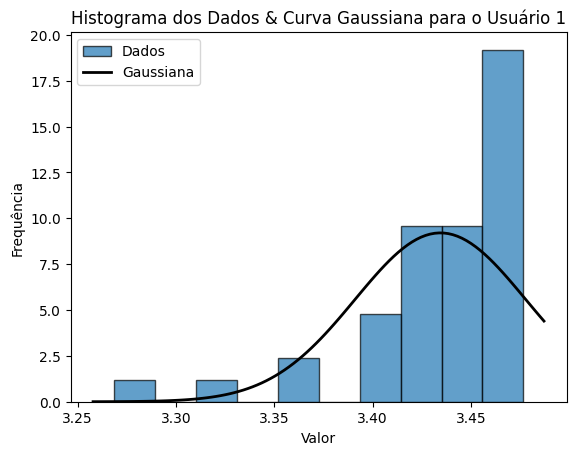



...... ......  ...... ......  ......  ......  ......  ...... ...... ...... ...... ...... ......  ...... ......  ......  ......  ......  ...... ...... ...... ......
Imagens do Grupo 2: 


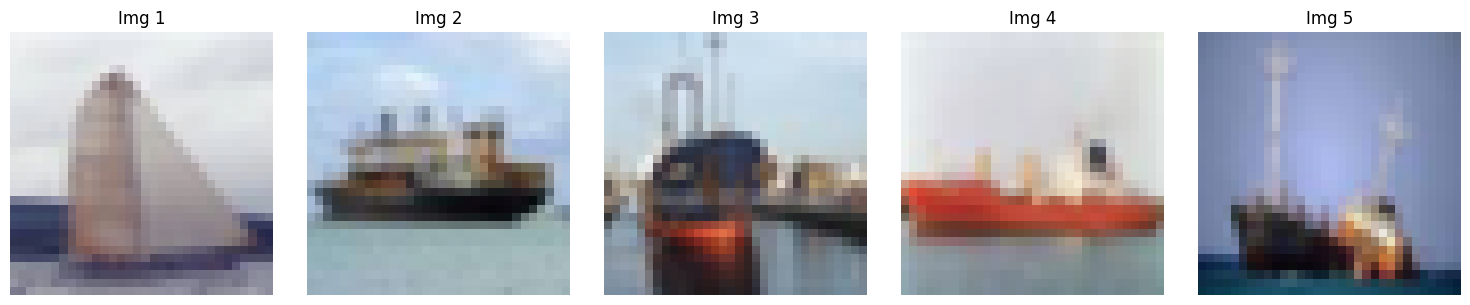

Valor da Mediana:  3.446420129557616
Valores do dataset Original (Chave|Valor): [0.0003690887304380828 0.00021530178827397964 ... 0.000692041511629142 0.0014917339779582678] ...
Valores do Conjunto (Chave|Valor) Não-Ordenado:  [(0, 3.463327768328069), (1, 3.4531933681507576), (2, 3.436242371672074), (3, 3.464192524349994), (4, 3.4475806647508875)]  ...
Valores do Conjunto (Chave|Valor) Ordenado:  [(28, 3.35721666392511), (34, 3.3782197922721653), (27, 3.4181910654399505), (39, 3.421191890885278), (32, 3.422547168237245)]  ...


Cal. Shapiro-Wilk, Statistica: 0.8808200359344 Valor-p: 0.0005538736 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.1052432342 Valor-p: 0.7280181251 Validação de Hipotese H0: Não Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 19.9470577478 Valor-p: 0.0000466178 Validação de Hipotese H0: Rejeitamos H0




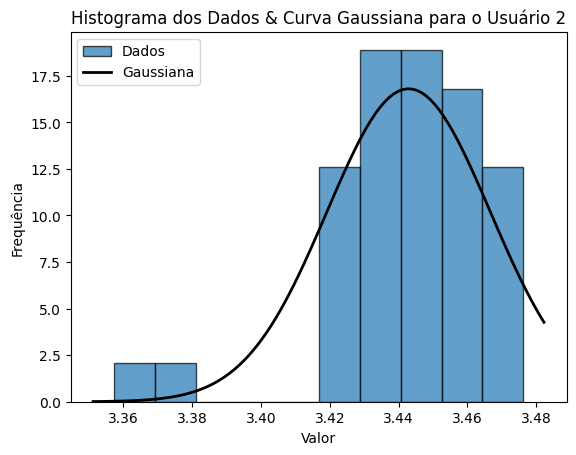



...... ......  ...... ......  ......  ......  ......  ...... ...... ...... ...... ...... ......  ...... ......  ......  ......  ......  ...... ...... ...... ......
Imagens do Grupo 3: 


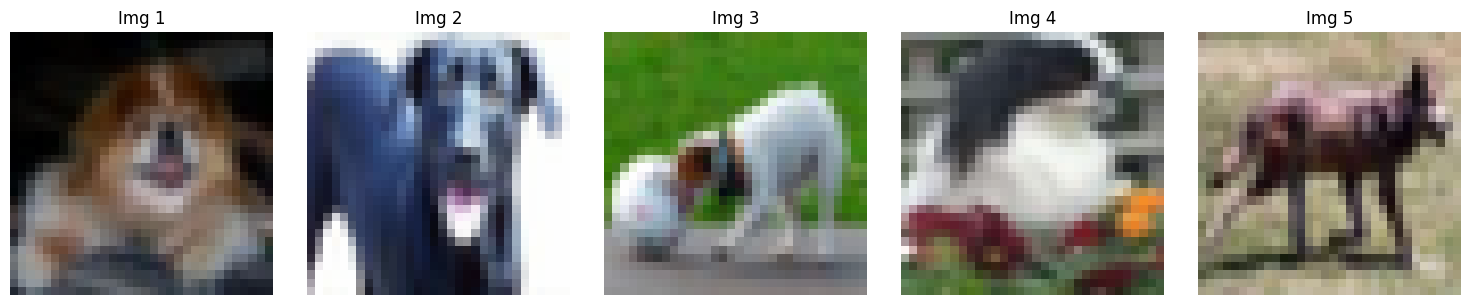

Valor da Mediana:  3.44039893952223
Valores do dataset Original (Chave|Valor): [3.075734418981215e-05 1.537868780248304e-05 ... 0.0005843906383888394 0.0006151480038960774] ...
Valores do Conjunto (Chave|Valor) Não-Ordenado:  [(0, 3.3445834388660884), (1, 3.3898503303289176), (2, 3.427400934126211), (3, 3.4255669769068997), (4, 3.4398195701783596)]  ...
Valores do Conjunto (Chave|Valor) Ordenado:  [(0, 3.3445834388660884), (17, 3.3661633358265752), (5, 3.372985914848525), (22, 3.3842340375612094), (1, 3.3898503303289176)]  ...


Cal. Shapiro-Wilk, Statistica: 0.9163726568222 Valor-p: 0.0059330366 Validação de Hipotese H0: Rejeitamos H0
Cal. Kolmogorov-Smirnov, Statistica: 0.1318973811 Valor-p: 0.4513016342 Validação de Hipotese H0: Não Rejeitamos H0
Cal. D'Agostino e Pearson's, Statistica: 4.3170027490 Valor-p: 0.1154980798 Validação de Hipotese H0: Não Rejeitamos H0




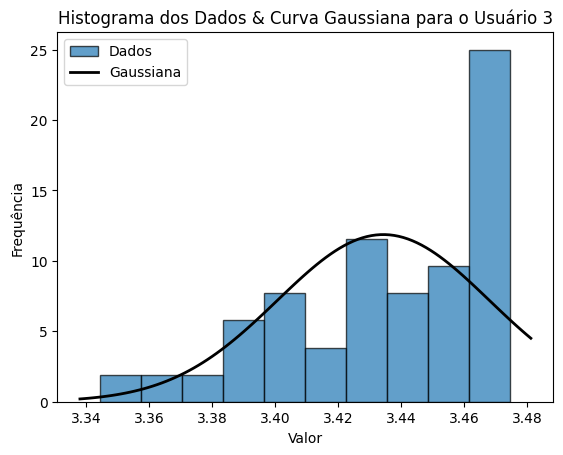

Total de Distribuições Gaussianas Encontradas:  0 | Total de Usuarios de até:  400


In [13]:
datasetGauss = cifar10NONIDD(num_users_cifar = 400, nclass_cifar = 2, nsamples_cifar = 20, rate_unbalance_cifar = 1.0, p = 100, q = 5, plotar = 5)

# ImageNet

In [14]:
# import tensorflow_datasets as tfds

# # Carregando o ImageNet
# imagenet_data, info = tfds.load("imagenet2012", with_info=True)
# train_data, test_data = imagenet_data['train'], imagenet_data['validation']
